# BLG-407 Makine Öğrenmesi - 2. Proje Ödevi: YOLOv8 ile Nesne Tespiti

**Ad:** Özge Zara
**Soyad:** Özçelik
**Okul Numarası:** 2212721014
**GitHub Repo Bağlantısı:** [GitHub linkini buraya yapıştıracaksın]

## Proje Tanımı
Bu proje kapsamında, bilgisayarlı görü alanında güncel ve yüksek performanslı bir model olan **YOLOv8 (You Only Look Once)** kullanılarak özel bir nesne tespiti modeli geliştirilmiştir. Projenin amacı, verilen görüntülerdeki giyim türlerini **"ust_giyim"** ve **"alt_giyim"** olmak üzere iki farklı sınıfta tespit etmektir.

## 1. Gerekli Kütüphanelerin Kurulumu ve Hazırlık
Bu aşamada, Ultralytics tarafından geliştirilen YOLOv8 kütüphanesi çalışma ortamına dahil edilmektedir. Model eğitimi için gerekli olan GPU (Grafik İşlemci) desteğinin aktif olup olmadığı `checks()` fonksiyonu ile kontrol edilir.

In [ ]:
# YOLOv8 kütüphanesini kuruyoruz
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/112.6 GB disk)


## 2. Veri Setinin Hazırlanması ve İndirilmesi
Proje için oluşturulan özgün veri seti Roboflow platformu üzerinden çekilmektedir. Veri seti hazırlanırken şu adımlar izlenmiştir:
* **Sınıflandırma:** `ust_giyim` ve `alt_giyim` olmak üzere 2 sınıf belirlenmiştir.
* **Veri Bölümleme:** Veriler %70 Eğitim (Train), %20 Doğrulama (Validation) ve %10 Test olarak ayrılmıştır.
* **Ön İşleme:** Tüm görüntüler YOLOv8 standartı olan **640x640** piksel boyutuna yeniden boyutlandırılmıştır (Resize).
* **Veri Zenginleştirme (Augmentation):** Modelin ezberlemesini önlemek ve başarısını artırmak için eğitim verilerine **Yatay Çevirme (Horizontal Flip)** uygulanarak veri sayısı yapay olarak artırılmıştır.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AFzRMlnEWS4TPml4kFyl")
project = rf.workspace("zge").project("kiyafet_tespiti")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## 3. YOLOv8 Model Eğitimi (Training)
Model eğitimi için **Transfer Learning (Transfer Öğrenme)** yöntemi kullanılmıştır. Sıfırdan bir model eğitmek yerine, COCO veri seti üzerinde önceden eğitilmiş ağırlıklara sahip **`yolov8n.pt` (Nano)** modeli başlangıç noktası olarak seçilmiştir. Nano model, düşük kaynak tüketimi ve yüksek hızı nedeniyle tercih edilmiştir.

**Eğitim Parametreleri:**
* **Epochs:** 50 (Model veriyi 50 kez tam tur görecek)
* **ImgSz:** 640 (Görüntü işleme boyutu)
* **Data:** Veri setinin konumunu belirten `data.yaml` dosyası
* **Batch Size:** Otomatik (GPU belleğine göre ayarlanır)

In [ ]:
from ultralytics import YOLO

# Modeli yükle (yolov8n en hızlısıdır, ödev için ideal)
model = YOLO('yolov8n.pt')

# Eğitimi başlat (50 epoch gayet yeterli)
results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=50,
    imgsz=640,
    name='kiyafet_modelim'
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Kiyafet_Tespiti-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=kiyafet_modelim5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

## 4. Eğitim Sonuçlarının Değerlendirilmesi
Eğitim tamamlandıktan sonra modelin başarısı **Confusion Matrix (Karmaşıklık Matrisi)** ve **mAP (mean Average Precision)** değerleri ile analiz edilir. Aşağıdaki grafikler, modelin sınıfları ne kadar doğru ayırt ettiğini göstermektedir.

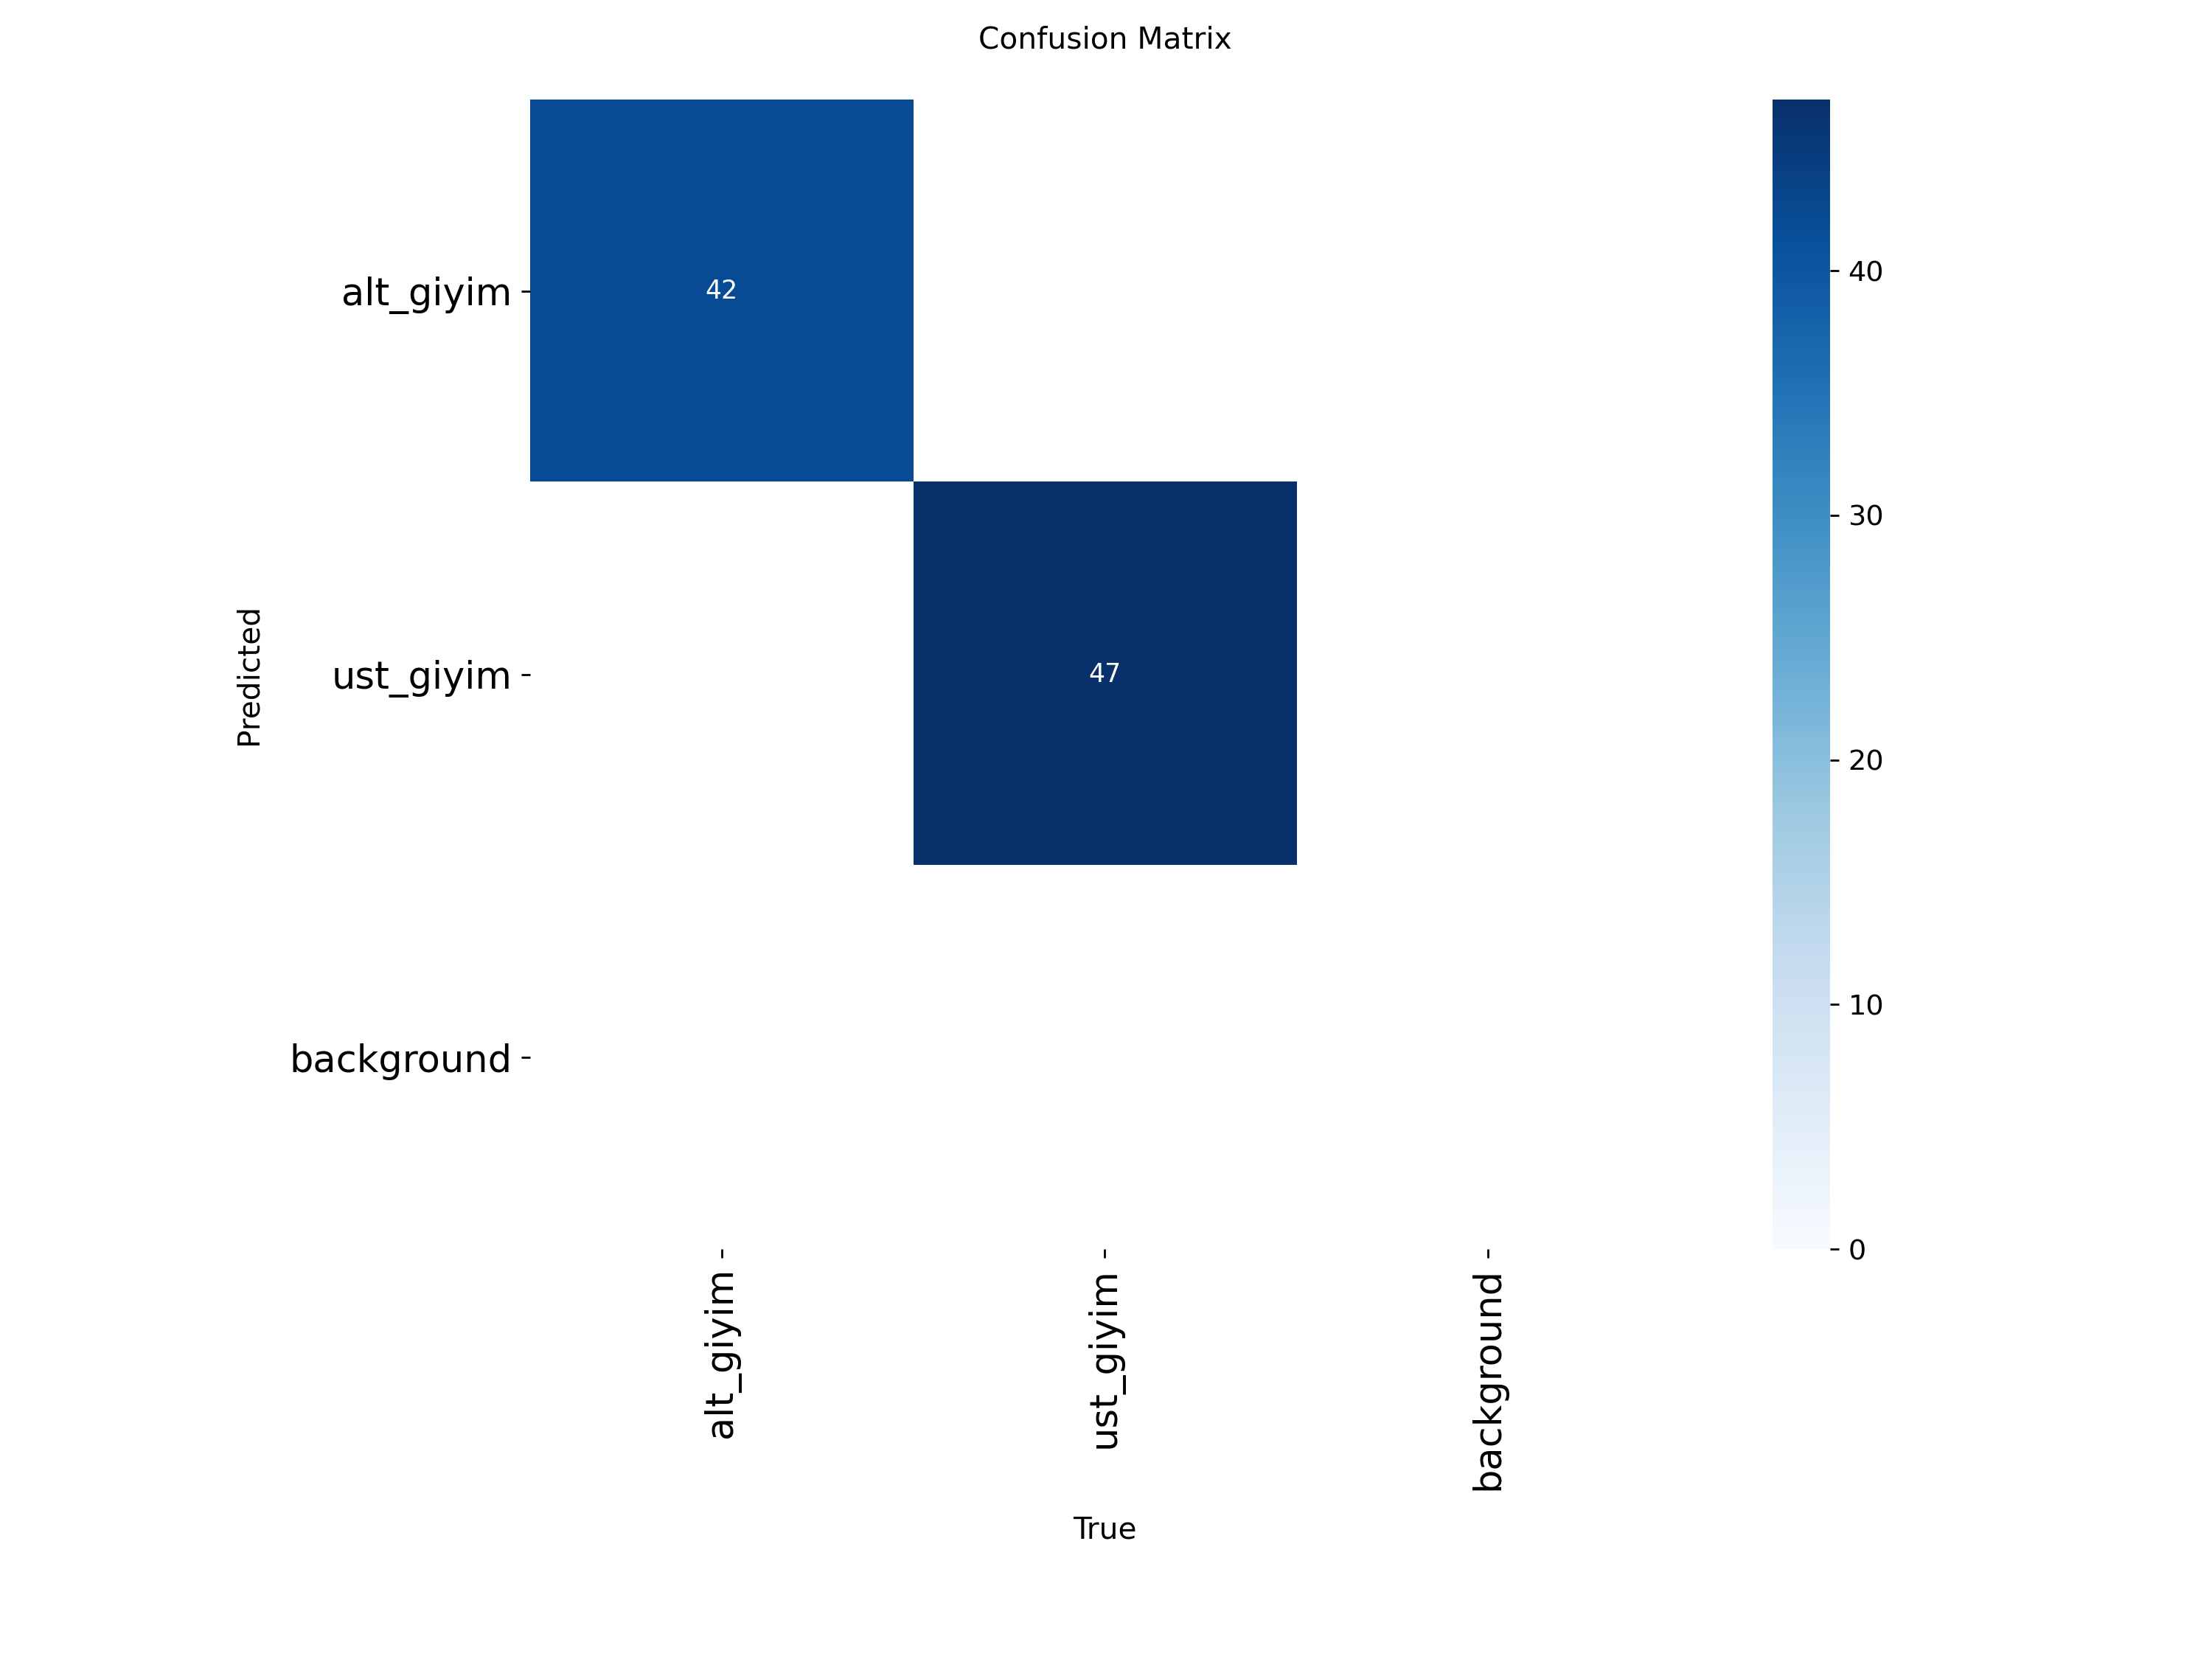

In [ ]:
from IPython.display import Image

# Dikkat: Klasör isminin sonuna '5' ekledim çünkü senin en son eğitimin orada.
display(Image(filename='/content/runs/detect/kiyafet_modelim5/confusion_matrix.png', width=600))

### Eğitim Süreci Grafikleri (Loss & mAP)
Aşağıdaki grafiklerde modelin 50 epoch (tekrar) boyunca sergilediği gelişim görülmektedir:
* **Box_Loss / Cls_Loss:** Eğitim ilerledikçe bu değerlerin (hata payının) **azalması** beklenir.
* **mAP50 (Mean Average Precision):** Modelin genel doğruluk skorudur. Eğitim ilerledikçe bu değerin **artması** ve 1.0'a yaklaşması beklenir.

Eğitim Metrikleri ve Başarım Grafiği:


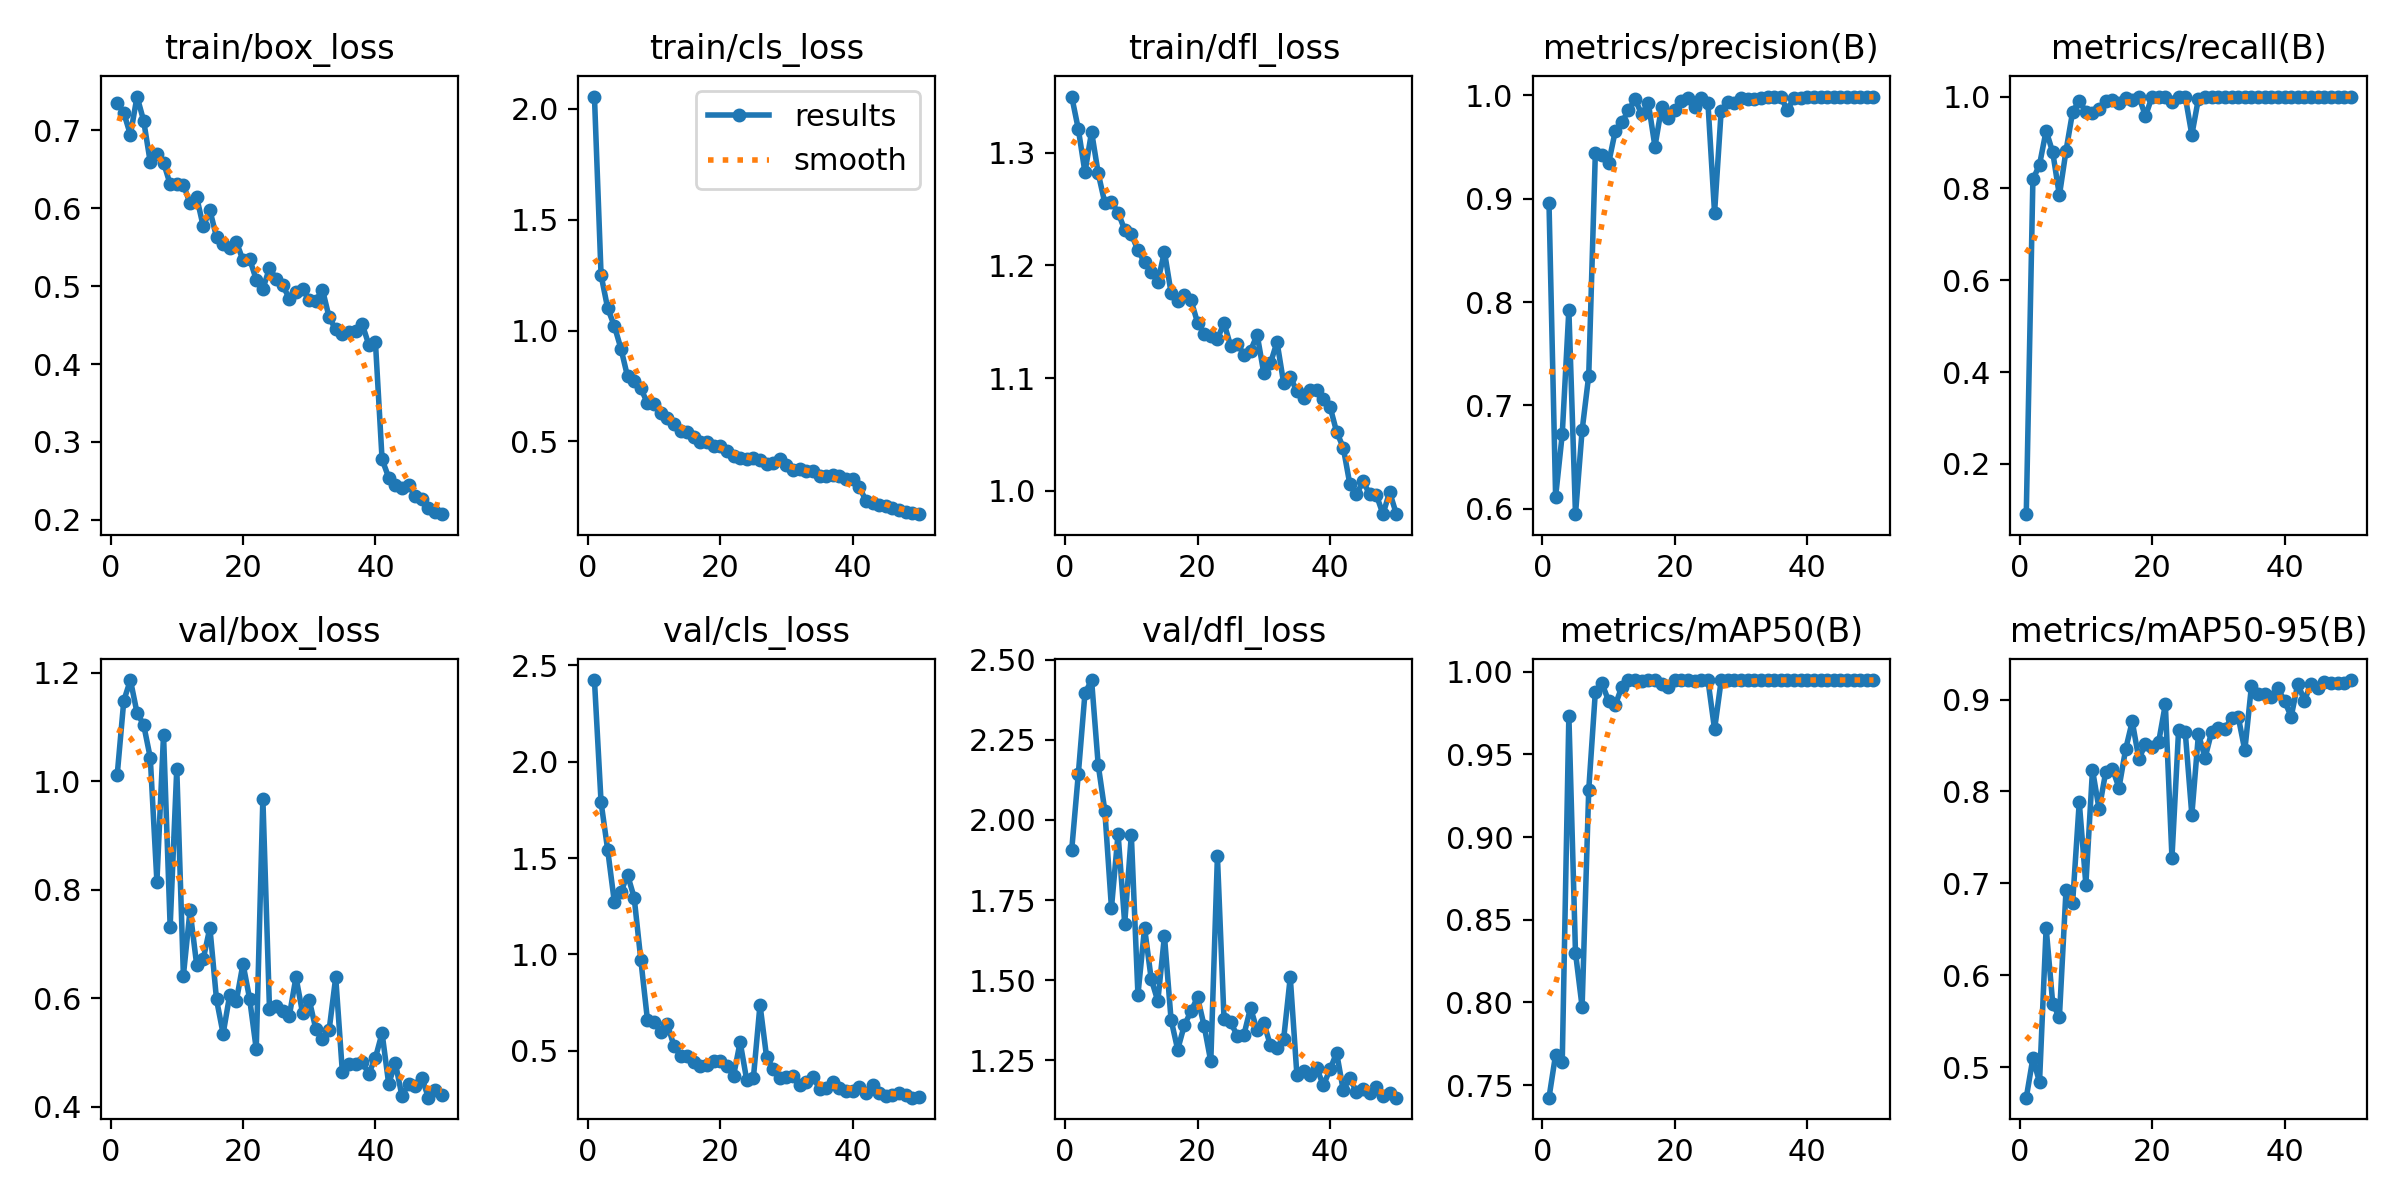

In [ ]:
# Eğitim sonuç grafiklerini (Loss ve Accuracy değişimi) ekrana bastır
print("Eğitim Metrikleri ve Başarım Grafiği:")
display(Image(filename=f'/content/runs/detect/kiyafet_modelim5/results.png', width=800))

## 5. Modelin Test Edilmesi (Inference)
Eğitilen modelin gerçek dünya performansını görmek amacıyla, test setinden rastgele bir görüntü seçilerek tahminleme (prediction) yapılmıştır.

Test edilen resim: IMG_7119_JPG.rf.0ca349d801c49732c2e0c6ae62a78cbe.jpg

image 1/1 /content/Kiyafet_Tespiti-1/test/images/IMG_7119_JPG.rf.0ca349d801c49732c2e0c6ae62a78cbe.jpg: 640x640 1 ust_giyim, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict


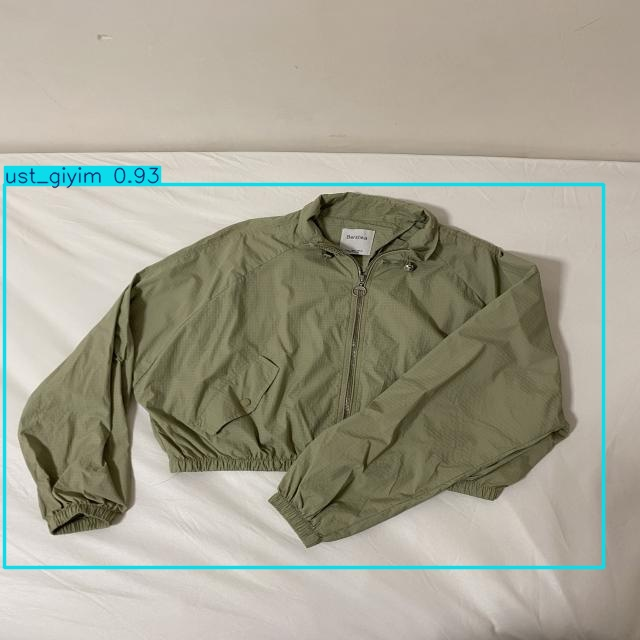

In [ ]:
import random
import glob
import os
from IPython.display import Image, display

# 1. Test klasöründeki resimleri bul (yol hatası olmasın diye dinamik yapıyoruz)
# Klasör adı Kiyafet_Tespiti-1, -2 vs olabilir, onu buluyoruz:
dataset_folders = glob.glob('/content/Kiyafet_Tespiti*')
# En sonuncuyu al (genelde doğru olan odur)
current_dataset = sorted(dataset_folders)[-1] if dataset_folders else '/content/Kiyafet_Tespiti-1'

test_images_path = f'{current_dataset}/test/images/*.jpg'
tum_test_resimleri = glob.glob(test_images_path)

if not tum_test_resimleri:
    print("HATA: Test resimleri bulunamadı! Lütfen yolu kontrol et.")
else:
    # 2. Rastgele bir resim seç
    secilen_resim = random.choice(tum_test_resimleri)

    # 3. Model ile tahmin yap
    print(f"Test edilen resim: {os.path.basename(secilen_resim)}")
    # save=True diyerek sonucu 'runs/detect/predict...' içine kaydeder
    results = model.predict(source=secilen_resim, save=True, conf=0.4)

    # 4. Sonuç resmini bul ve göster
    # YOLO her tahminde yeni predict klasörü açar (predict, predict2...), en sonuncuyu alıyoruz
    predict_dirs = sorted(glob.glob('/content/runs/detect/predict*'), key=os.path.getmtime)
    son_predict_klasoru = predict_dirs[-1]
    sonuc_resmi_yolu = f"{son_predict_klasoru}/{os.path.basename(secilen_resim)}"

    display(Image(filename=sonuc_resmi_yolu, width=600))